### Importing the necessary libraries first.

For functionality: numpy, pandas, matplotlib <br />For machine learning: sklearn

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [109]:
# load the dataset...
data = pd.read_csv('loan_data.csv')
# ...and have a look at the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


### One categorical feature - this needs one-hot encoding for the classifier.

In [3]:
purpose_encoded = pd.get_dummies(data.purpose, prefix='purpose')

### Checking the class distribution.

In [115]:
data['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

The classes aren't balanced, but the difference isn't significant enough to cause a problem for a decent classifier.

### Checking the distribution of the numerical features.

In [65]:
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


### Since the scale varies so much, it's best to standardise these features first.

In [23]:
numerical_only = data.drop(['purpose', 'not.fully.paid'], axis=1)
array = numerical_only.values
scaled_array = StandardScaler().fit_transform(array)
scaled_data = pd.DataFrame(scaled_array, index=numerical_only.index, columns=numerical_only.columns)

### Combine the scaled and encoded features (and the targets) back into a clean dataframe.

In [26]:
data_clean = pd.concat([scaled_data, purpose_encoded, data['not.fully.paid']], axis=1)

In [27]:
data_clean.head(2)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,not.fully.paid
0,0.492222,-0.139318,2.463099,0.680388,0.998505,0.688825,0.43223,0.353732,0.182704,-0.716989,-0.29973,-0.237003,0,0,1,0,0,0,0,0
1,0.492222,-0.578868,-0.438854,0.244031,0.244540,-0.101303,-0.72123,0.495018,1.030602,-0.716989,-0.29973,-0.237003,0,1,0,0,0,0,0,0


### Ready for classification!

In [28]:
# Split the data...
features = data_clean.drop(columns=['not.fully.paid'])
# ...into features and targets
targets = data_clean['not.fully.paid']

### Create training and testing sets.

In [66]:
trainX, testX, trainY, testY = train_test_split(features, targets, train_size=0.7, random_state=125)

## Classifying with a Random Forest.

### Use a gridsearch to optimise over some key hyperparameters.

In [39]:
grid = {'n_estimators': np.arange(100, 1000, 100),
        'max_depth': np.arange(1, 5, 1)}

In [43]:
model = RandomForestClassifier()

In [44]:
tuner = GridSearchCV(model, grid, scoring='roc_auc', cv=5, verbose=1)

In [45]:
tuner.fit(trainX, trainY)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  5.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='roc_auc', verbose=1)

In [46]:
results = tuner.cv_results_
bestRFC = tuner.best_estimator_
bestAUC = tuner.best_score_
print(f"Model: {bestRFC}. Score: {bestAUC:.3}")

Model: RandomForestClassifier(max_depth=4). Score: 0.683


The AUC score could be better, but this isn't bad!

### We have a classifier... let's make a prediction and see how it performs.

In [76]:
train_pred = bestRFC.predict_proba(trainX)[:,1] # keep the probability
test_pred = bestRFC.predict_proba(testX)[:,1]   # of a positive label

### Test for overfitting by comparing the ROC curves.

In [77]:
fpr1, tpr1, thresh = roc_curve(trainY.values, train_pred)
fpr2, tpr2, thresh = roc_curve(testY.values, test_pred)
trainscore = roc_auc_score(trainY.values, train_pred)
testscore = roc_auc_score(testY.values, test_pred)

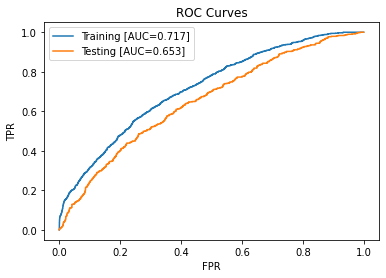

In [78]:
plt.title("ROC Curves")
plt.plot(fpr1, tpr1, label=f'Training [AUC={trainscore:.3}]')
plt.plot(fpr2, tpr2, label=f'Testing [AUC={testscore:.3}]')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

Performance is fairly consistent over the testing and training sets, so this isn't a bad fit.

### Select a classification threshold to work with.

In [97]:
tprfpr = tpr2-fpr2
best_idx = np.argmax(tprfpr)
possible_threshold = thresh[best_idx]

In [98]:
pred_v_true = testY.to_frame(name='true').assign(pred=test_pred)

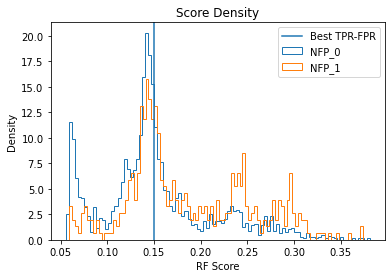

In [100]:
plt.hist(pred_v_true['pred'].loc[pred_v_true['true']==0], histtype='step', density=True, bins=100, label='NFP_0')
plt.hist(pred_v_true['pred'].loc[pred_v_true['true']==1], histtype='step', density=True, bins=100, label='NFP_1')
plt.axvline(possible_threshold, label='Best TPR-FPR')
plt.xlabel('RF Score')
plt.ylabel("Density")
plt.title("Score Density")
plt.legend()
plt.show()

The illustrated threshold looks like the best choice.

### Threshold chosen - check the confusion matrix for performance.

In [102]:
array = np.zeros(len(pred_v_true))
pred_v_true['binary_pred'] = array
# this will kick a warning but it's a false positive, don't worry!
pred_v_true['binary_pred'].loc[pred_v_true['pred']>=possible_threshold] = 1

c:\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


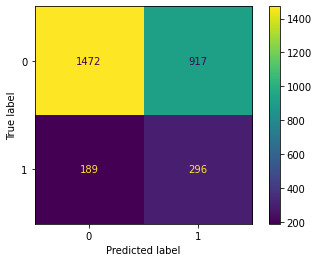

In [106]:
CM = confusion_matrix(pred_v_true.true, pred_v_true.binary_pred)
CMD = ConfusionMatrixDisplay(CM).plot()

### Due to the class imbalance, this is probably better illustrated by normalising.

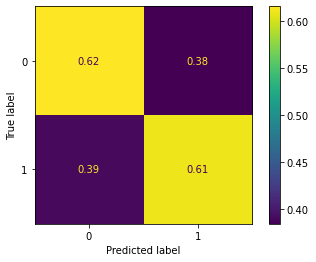

In [107]:
CMn = confusion_matrix(pred_v_true.true, pred_v_true.binary_pred, normalize='true')
CMDn = ConfusionMatrixDisplay(CMn).plot()